In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

2025-04-01 15:33:23.874790: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 15:33:24.002015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 15:33:24.108178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743518004.202213    4233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743518004.231204    4233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743518004.435580    4233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


E0000 00:00:1743518006.984997    4233 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743518007.022309    4233 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Loading the dataset and preparing it for training
train_path = '../dataset_organized/train/'
test_path = '../dataset_organized/test/'
val_path = '../dataset_organized/validation/'

# Loading the dataset
import os
import cv2
from tqdm import tqdm

def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)
X_val, y_val = load_images(val_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# One hot encoding the target variable
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)
y_val = to_categorical(y_val_encoded)

# Splitting the training set into training and validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

  0%|          | 0/403 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 1495.30it/s]


# Base Resnet

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 667ms/step - accuracy: 0.2062 - loss: 1.7906 - val_accuracy: 0.2896 - val_loss: 1.6991
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 624ms/step - accuracy: 0.2371 - loss: 1.7271 - val_accuracy: 0.2530 - val_loss: 1.6810
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.2444 - loss: 1.7151 - val_accuracy: 0.2805 - val_loss: 1.6754
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 631ms/step - accuracy: 0.2499 - loss: 1.6995 - val_accuracy: 0.2744 - val_loss: 1.6636
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 625ms/step - accuracy: 0.2713 - loss: 1.6970 - val_accuracy: 0.3049 - val_loss: 1.6530
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 612ms/step - accuracy: 0.2668 - loss: 1.6785 - val_accuracy: 0.2439 - val_loss: 1.6452
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 602ms/step - accuracy: 0.2481 - loss: 1.6961 - val_accuracy: 0.2439 - val_loss: 1.6361
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 576ms/step - accuracy: 0.2793 - loss: 1.6736 - val_accu

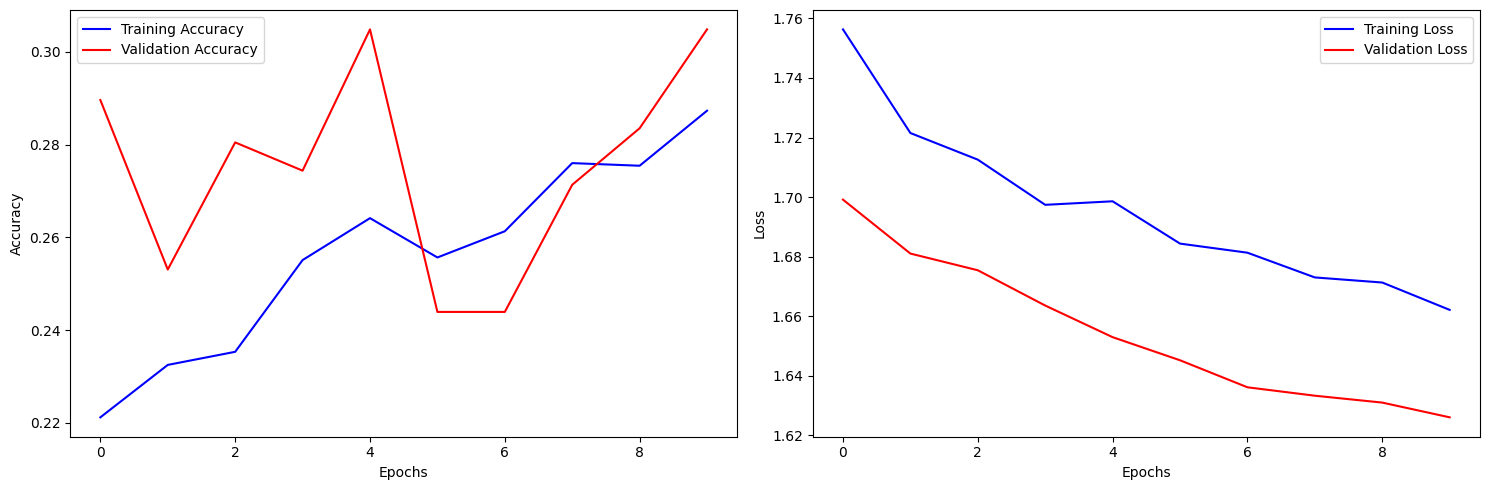

Training Accuracy: 0.2873303294181824
Validation Accuracy: 0.3048780560493469
Training Loss: 1.66212797164917
Validation Loss: 1.626053810119629


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, batch_size=32, validation_data=(X_val, y_val))

# saving the model
model.save('aug_resnet_model.h5')
plt.figure(figsize=(15, 5))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])

print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])

# Building the ResNet model with L2 Regularization


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - accuracy: 0.2253 - loss: 1.9121 - val_accuracy: 0.2561 - val_loss: 1.6943
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.2616 - loss: 1.7133 - val_accuracy: 0.3262 - val_loss: 1.6669
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 596ms/step - accuracy: 0.2447 - loss: 1.7020 - val_accuracy: 0.3110 - val_loss: 1.6589
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.2953 - loss: 1.6787 - val_accuracy: 0.2409 - val_loss: 1.6557
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 606ms/step - accuracy: 0.2502 - loss: 1.6825 - val_accuracy: 0.2256 - val_loss: 1.6882
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.2797 - loss: 1.6699 - val_accuracy: 0.3079 - val_loss: 1.6516
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 562ms/step - accuracy: 0.3022 - loss: 1.6554 - val_accuracy: 0.3293 - val_loss: 1.6655
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 557ms/step - accuracy: 0.2694 - loss: 1.6570 - val_accu

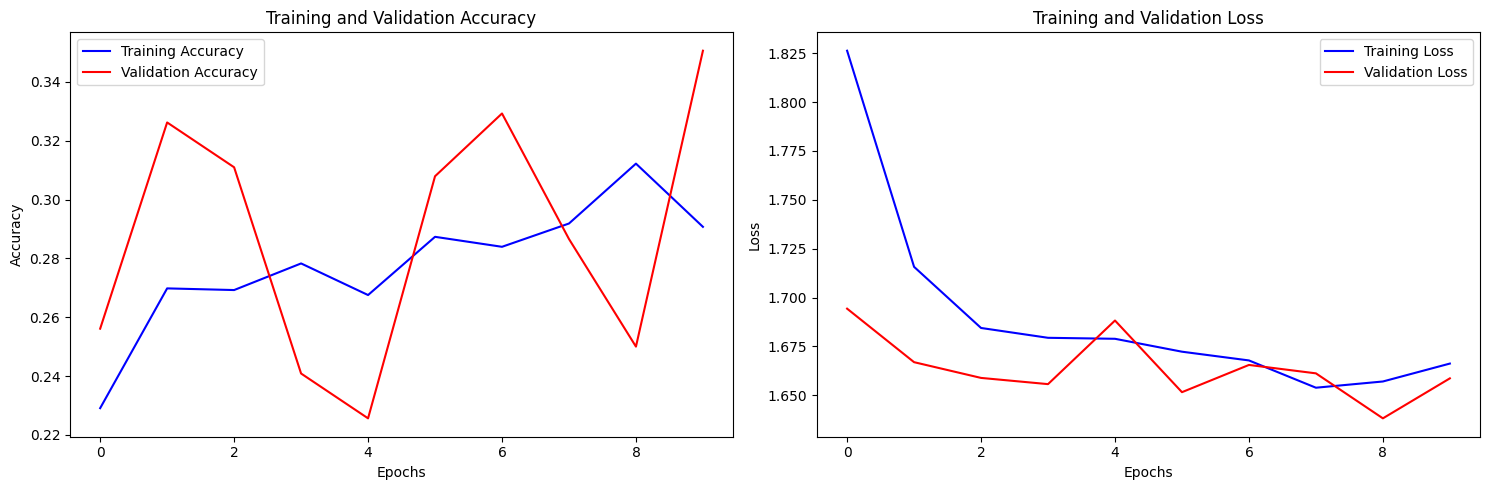

Training Accuracy: 0.290723979473114
Validation Accuracy: 0.35060974955558777
Training Loss: 1.6662019491195679
Validation Loss: 1.6586335897445679


In [ ]:
from keras.regularizers import l2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('aug_resnet_model_l2.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the ResNet model with L1 Regularization


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - accuracy: 0.1987 - loss: 6.0348 - val_accuracy: 0.2988 - val_loss: 2.0786
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 683ms/step - accuracy: 0.2403 - loss: 1.9799 - val_accuracy: 0.2530 - val_loss: 1.8507
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.2373 - loss: 1.8568 - val_accuracy: 0.1860 - val_loss: 1.8075
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 579ms/step - accuracy: 0.2341 - loss: 1.8233 - val_accuracy: 0.2927 - val_loss: 1.7876
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 573ms/step - accuracy: 0.2433 - loss: 1.8084 - val_accuracy: 0.2561 - val_loss: 1.7613
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 571ms/step - accuracy: 0.2589 - loss: 1.7927 - val_accuracy: 0.2622 - val_loss: 1.7427
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.2716 - loss: 1.7781 - val_accuracy: 0.2439 - val_loss: 1.7673
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 564ms/step - accuracy: 0.2603 - loss: 1.7923 - val_accu

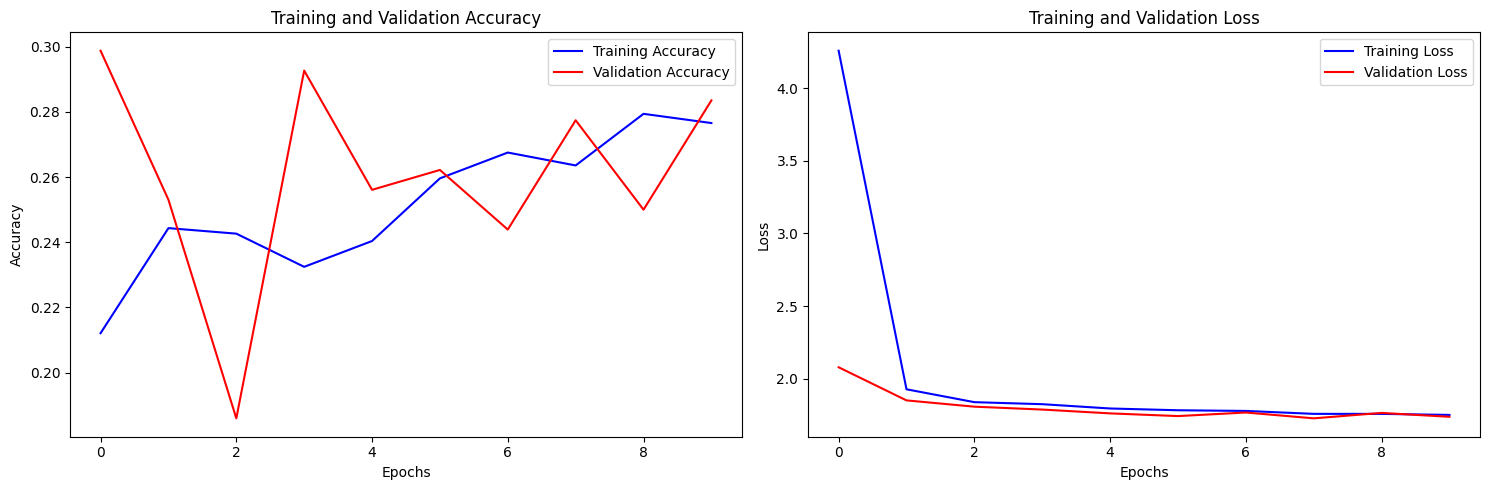

Training Accuracy: 0.2765837013721466
Validation Accuracy: 0.2835365831851959
Training Loss: 1.7507673501968384
Validation Loss: 1.737812876701355


In [ ]:

from keras.regularizers import l1

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('aug_resnet_model_l1.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the ResNet model with Dropout Regularization


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 633ms/step - accuracy: 0.2029 - loss: 1.8574 - val_accuracy: 0.2012 - val_loss: 1.7111
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.2505 - loss: 1.7261 - val_accuracy: 0.2470 - val_loss: 1.6839
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.2386 - loss: 1.7082 - val_accuracy: 0.2409 - val_loss: 1.6784
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.2466 - loss: 1.6962 - val_accuracy: 0.2744 - val_loss: 1.6677
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 570ms/step - accuracy: 0.2487 - loss: 1.6925 - val_accuracy: 0.2744 - val_loss: 1.6574
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 568ms/step - accuracy: 0.2357 - loss: 1.6938 - val_accuracy: 0.2409 - val_loss: 1.6440
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 565ms/step - accuracy: 0.2589 - loss: 1.6793 - val_accuracy: 0.2866 - val_loss: 1.6439
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 567ms/step - accuracy: 0.2742 - loss: 1.6595 - val_accu

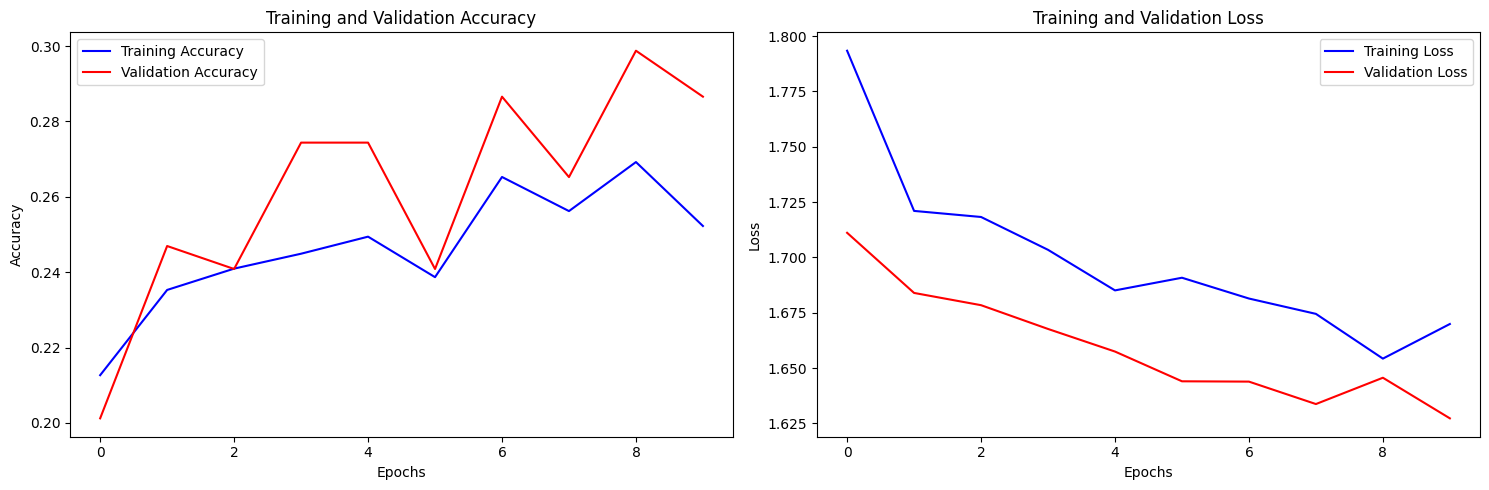

Training Accuracy: 0.2522624433040619
Validation Accuracy: 0.28658536076545715
Training Loss: 1.6698927879333496
Validation Loss: 1.6272549629211426


In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Saving the model
model.save('aug_resnet_model_dropout.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the ResNet model with EarlyStopping


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 629ms/step - accuracy: 0.2139 - loss: 1.7892 - val_accuracy: 0.2530 - val_loss: 1.6908
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 567ms/step - accuracy: 0.2592 - loss: 1.6895 - val_accuracy: 0.2500 - val_loss: 1.6660
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.2448 - loss: 1.6874 - val_accuracy: 0.2805 - val_loss: 1.6447
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 564ms/step - accuracy: 0.2560 - loss: 1.6566 - val_accuracy: 0.2835 - val_loss: 1.6399
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 575ms/step - accuracy: 0.2747 - loss: 1.6584 - val_accuracy: 0.2988 - val_loss: 1.6494
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 564ms/step - accuracy: 0.3132 - loss: 1.6224 - val_accuracy: 0.2409 - val_loss: 1.6471
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 586ms/step - accuracy: 0.2999 - loss: 1.6324 - val_accuracy: 0.2927 - val_loss: 1.6248
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 581ms/step - accuracy: 0.2973 - loss: 1.6461 - val_accu

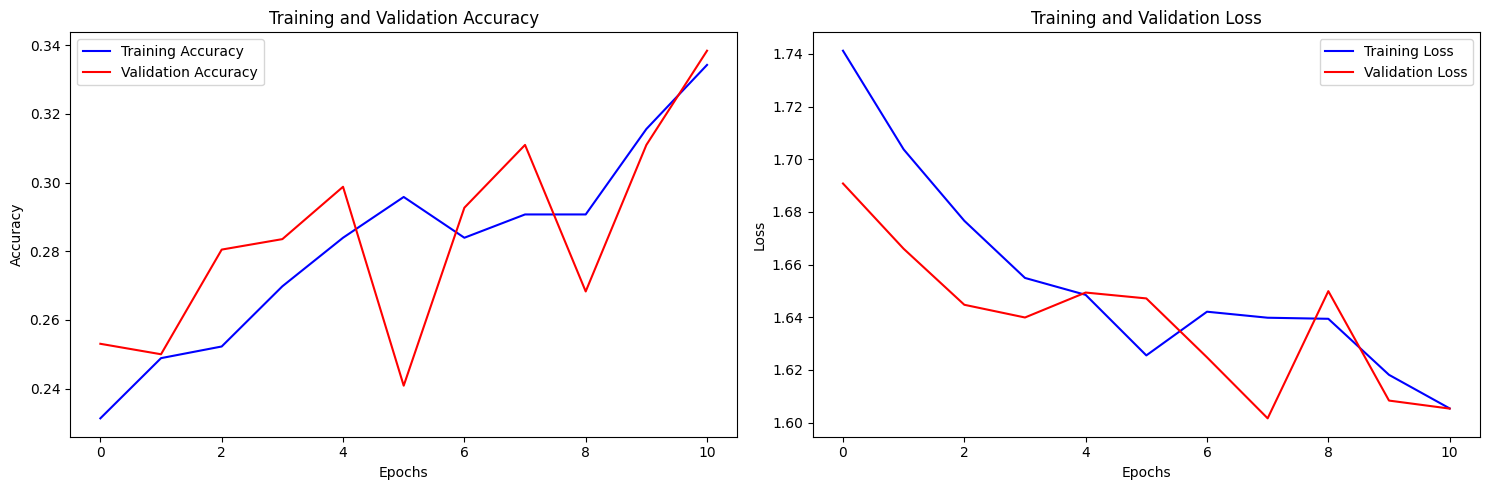

Training Accuracy: 0.334276020526886
Validation Accuracy: 0.33841463923454285
Training Loss: 1.6053515672683716
Validation Loss: 1.605288028717041


In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Saving the model
model.save('aug_resnet_model_es.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


# Building the ResNet model with Dropout + EarlyStopping


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 606ms/step - accuracy: 0.2018 - loss: 1.8518 - val_accuracy: 0.2530 - val_loss: 1.6953
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.2075 - loss: 1.7409 - val_accuracy: 0.2470 - val_loss: 1.7012
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 558ms/step - accuracy: 0.2135 - loss: 1.7350 - val_accuracy: 0.2805 - val_loss: 1.6913
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 552ms/step - accuracy: 0.2455 - loss: 1.7094 - val_accuracy: 0.2713 - val_loss: 1.6752
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.2951 - loss: 1.6879 - val_accuracy: 0.2927 - val_loss: 1.6535
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.2413 - loss: 1.7065 - val_accuracy: 0.2835 - val_loss: 1.6547
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 557ms/step - accuracy: 0.2720 - loss: 1.6848 - val_accuracy: 0.2835 - val_loss: 1.6384
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 559ms/step - accuracy: 0.2609 - loss: 1.6800 - val_accu

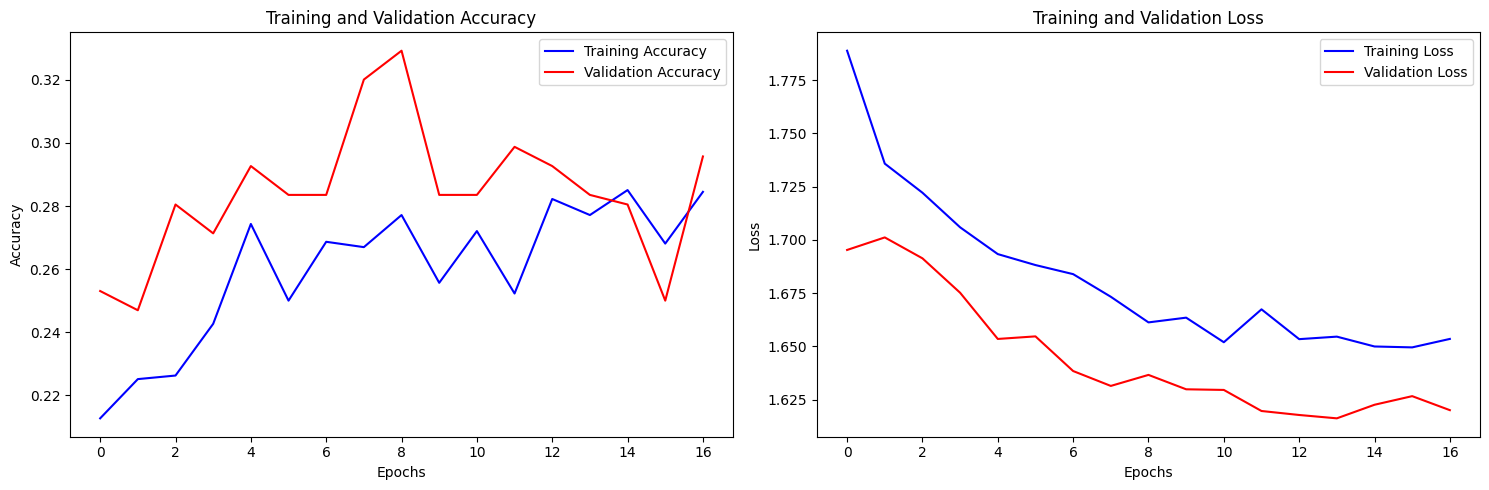

Training Accuracy: 0.2845022678375244
Validation Accuracy: 0.29573169350624084
Training Loss: 1.6535074710845947
Validation Loss: 1.6200588941574097


In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Saving the model
model.save('aug_resnet_model_de.h5')

# Plotting the training and validation accuracy and loss side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])
print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    accuracy_score, roc_curve, auc,
    classification_report, confusion_matrix
)

def evaluate_model(predictions, y_true, class_names):
    # F1 Score
    f1 = f1_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("F1 Score: ", f1)

    # Precision
    precision = precision_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("Precision: ", precision)

    # Recall
    recall = recall_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), average='weighted')
    print("Recall: ", recall)

    # Accuracy
    accuracy = accuracy_score(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1))
    print("Accuracy: ", accuracy)

    # Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1))

    # Plot ROC + Confusion Matrix in one figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # ROC Curve Plot
    for i in range(len(class_names)):
        axes[0].plot(fpr[i], tpr[i], label=class_names[i] + f' (AUC = {roc_auc[i]:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()

    # Confusion Matrix Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Classification Report
    print(classification_report(np.argmax(y_true, axis=1), np.argmax(predictions, axis=1), target_names=class_names))



Loading the model



Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.4505 - loss: 1.4998
Test Loss: 1.6486834287643433
Test Accuracy: 0.34106728434562683
F1 Score:  0.25904661765284037
Precision:  0.2099476387863095
Recall:  0.34106728538283065
Accuracy:  0.34106728538283065


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


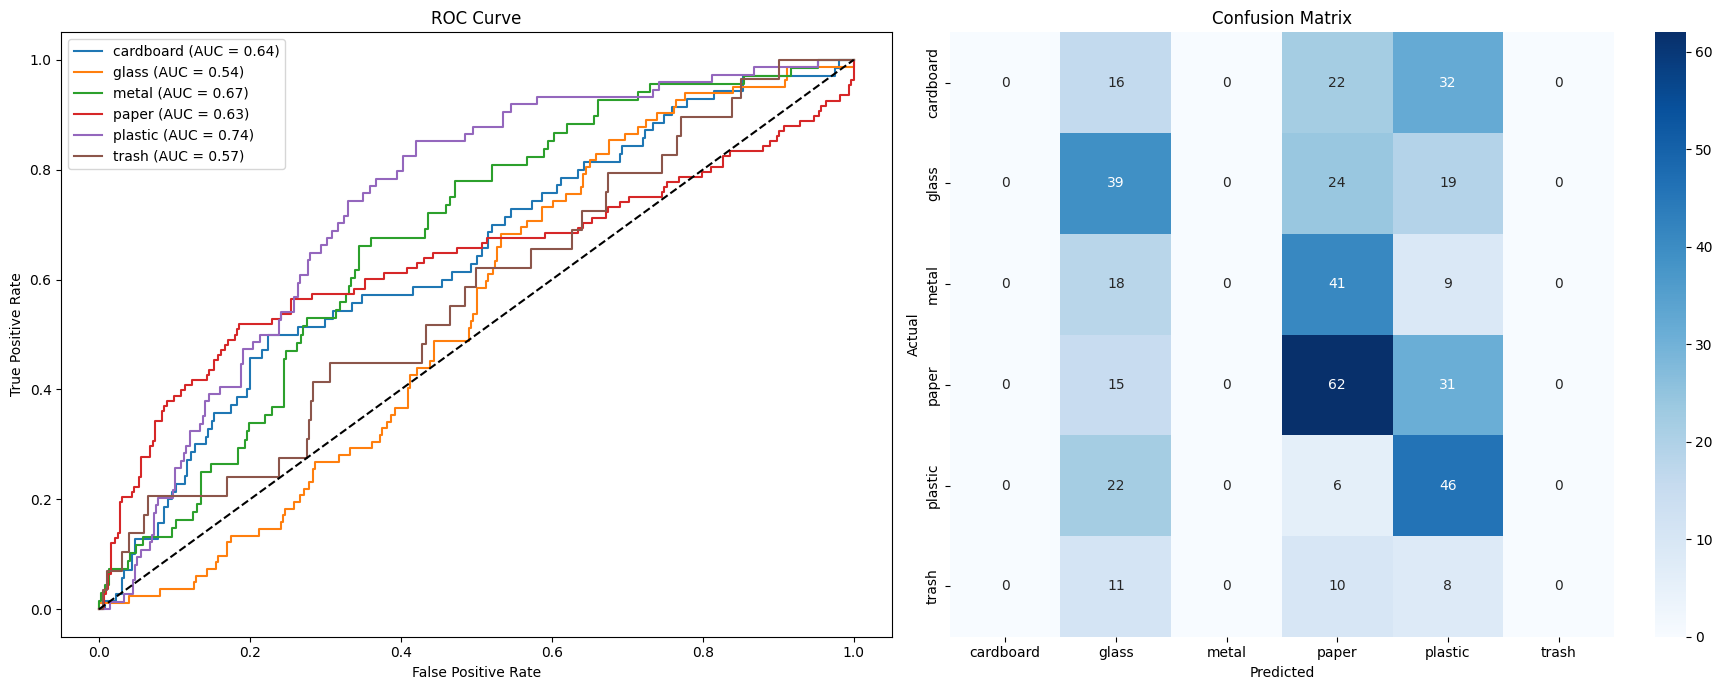

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.32      0.48      0.38        82
       metal       0.00      0.00      0.00        68
       paper       0.38      0.57      0.45       108
     plastic       0.32      0.62      0.42        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.34       431
   macro avg       0.17      0.28      0.21       431
weighted avg       0.21      0.34      0.26       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 647ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 0.4663 - loss: 1.5023
Test Loss: 1.661478877067566
Test Accuracy: 0.37122970819473267
F1 Score:  0.3175478208551798
Precision:  0.3194691648313912
Recall:  0.37122969837587005
Accuracy:  0.37122969837587005


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


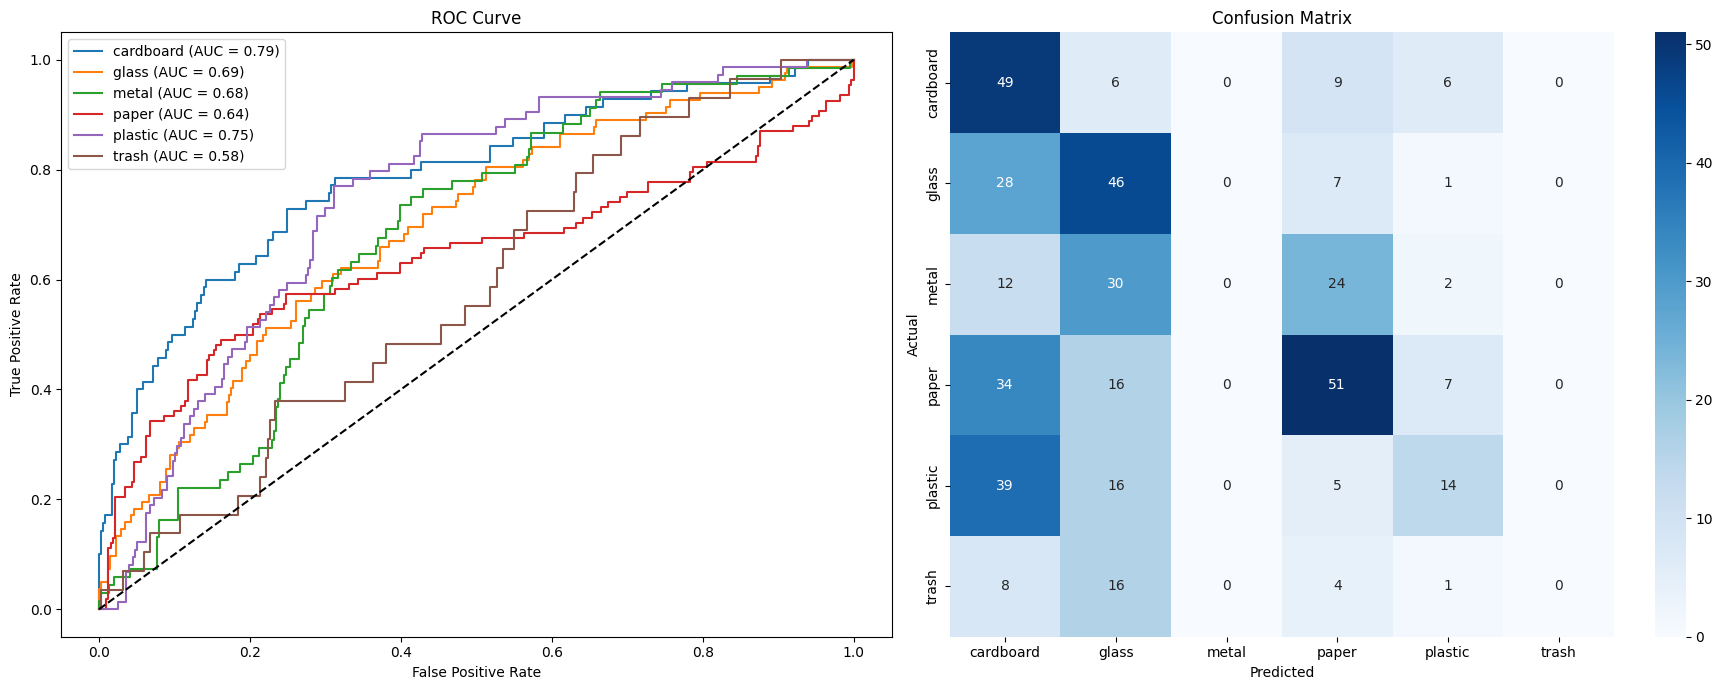

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

   cardboard       0.29      0.70      0.41        70
       glass       0.35      0.56      0.43        82
       metal       0.00      0.00      0.00        68
       paper       0.51      0.47      0.49       108
     plastic       0.45      0.19      0.27        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.37       431
   macro avg       0.27      0.32      0.27       431
weighted avg       0.32      0.37      0.32       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 562ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.3456 - loss: 1.7237
Test Loss: 1.7737034559249878
Test Accuracy: 0.2969837486743927
F1 Score:  0.23804860722870413
Precision:  0.28240900381964806
Recall:  0.29698375870069604
Accuracy:  0.29698375870069604


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


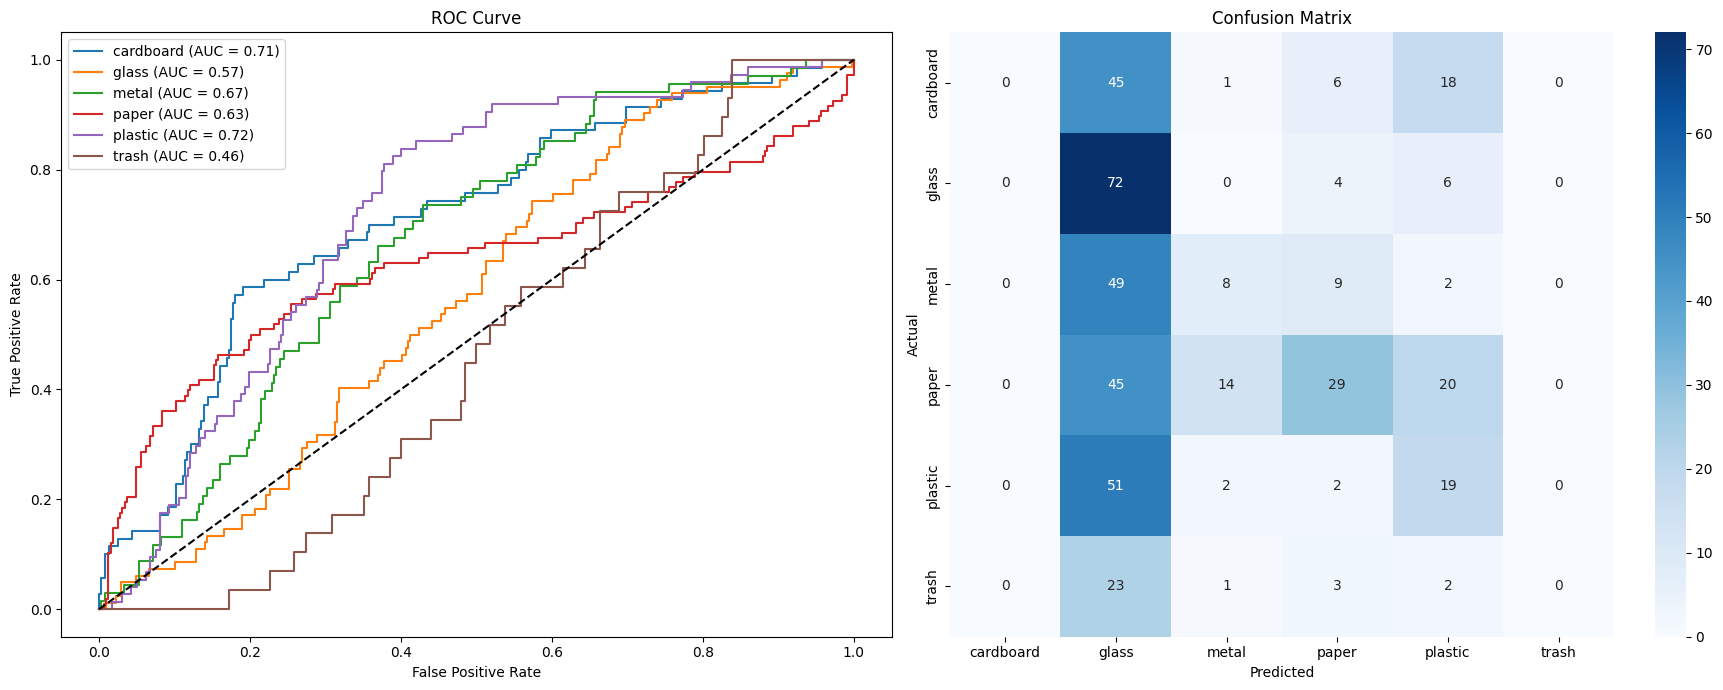

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.25      0.88      0.39        82
       metal       0.31      0.12      0.17        68
       paper       0.55      0.27      0.36       108
     plastic       0.28      0.26      0.27        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.30       431
   macro avg       0.23      0.25      0.20       431
weighted avg       0.28      0.30      0.24       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - accuracy: 0.4649 - loss: 1.4971
Test Loss: 1.6522963047027588
Test Accuracy: 0.34106728434562683
F1 Score:  0.2519439227337233
Precision:  0.21521657919928025
Recall:  0.34106728538283065
Accuracy:  0.34106728538283065


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


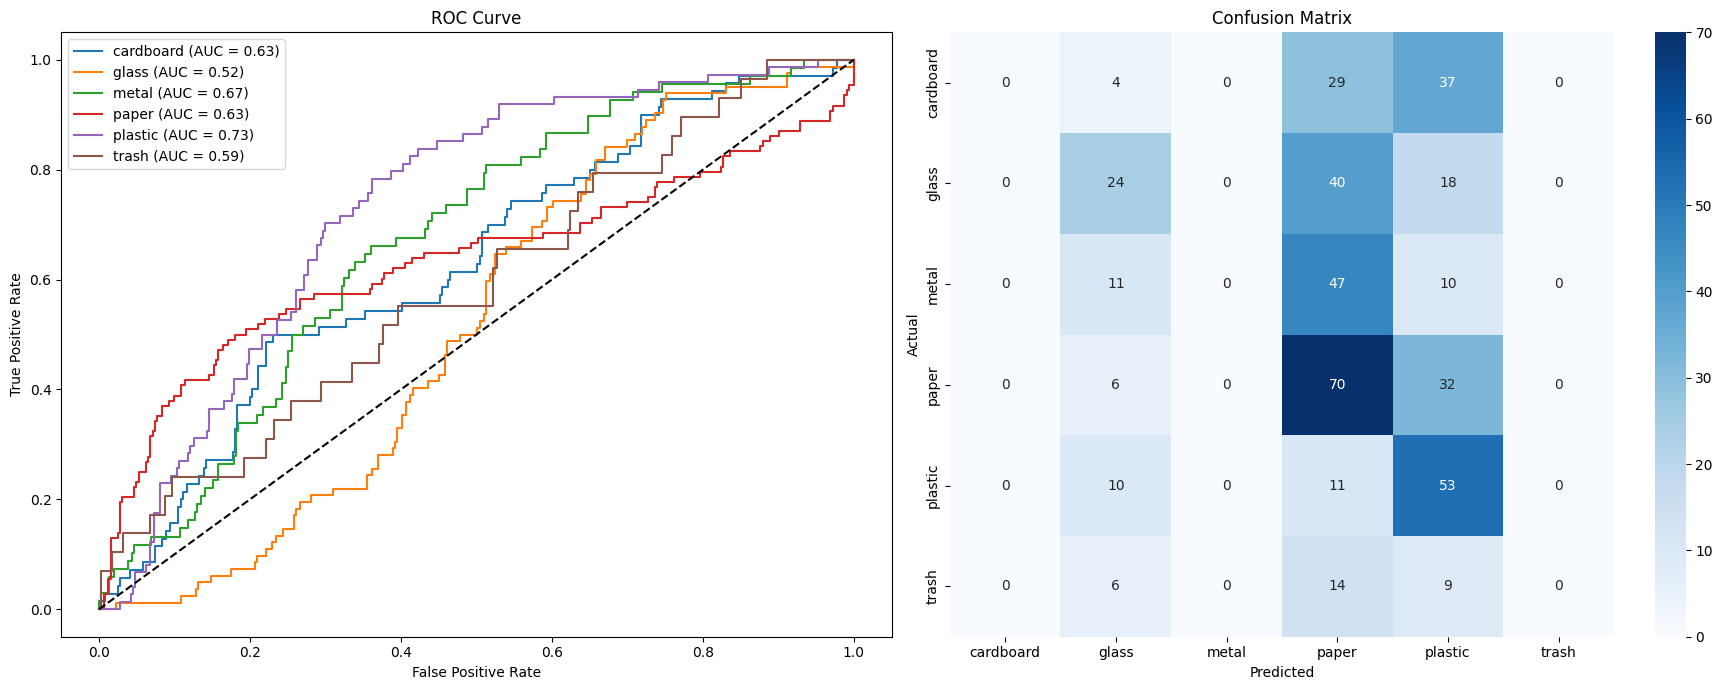

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.39      0.29      0.34        82
       metal       0.00      0.00      0.00        68
       paper       0.33      0.65      0.44       108
     plastic       0.33      0.72      0.45        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.34       431
   macro avg       0.18      0.28      0.20       431
weighted avg       0.22      0.34      0.25       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 568ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.3774 - loss: 1.4879
Test Loss: 1.6169227361679077
Test Accuracy: 0.35730859637260437
F1 Score:  0.3023014233342652
Precision:  0.2893953920345915
Recall:  0.35730858468677495
Accuracy:  0.35730858468677495


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


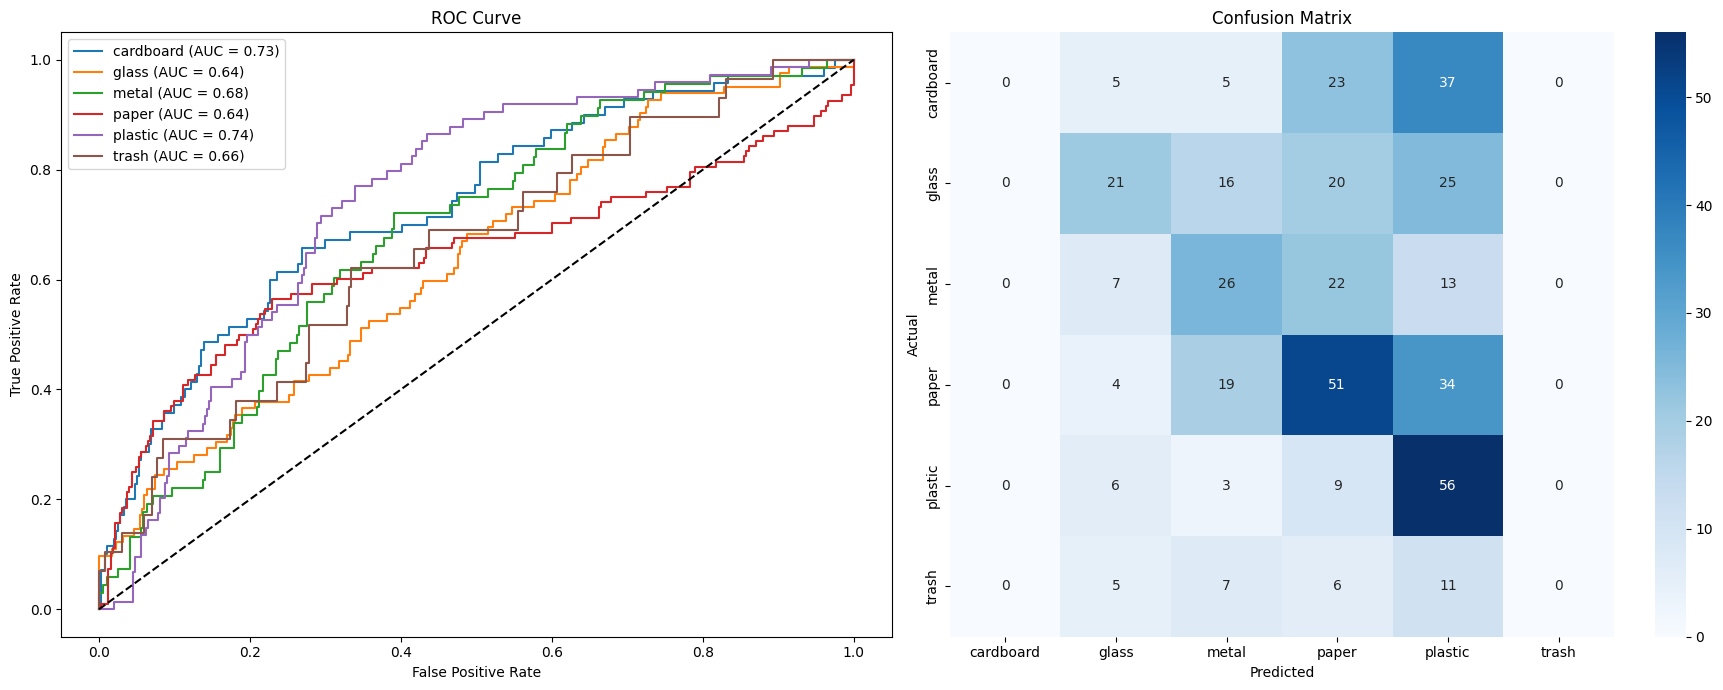

/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.44      0.26      0.32        82
       metal       0.34      0.38      0.36        68
       paper       0.39      0.47      0.43       108
     plastic       0.32      0.76      0.45        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.36       431
   macro avg       0.25      0.31      0.26       431
weighted avg       0.29      0.36      0.30       431


Evaluating the model
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.4605 - loss: 1.4626
Test Loss: 1.6421637535095215
Test Accuracy: 0.29930394887924194
F1 Score:  0.22391137554197074
Precision:  0.1815079234761262
Recall:  0.29930394431554525
Accuracy:  0.29930394431554525


/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


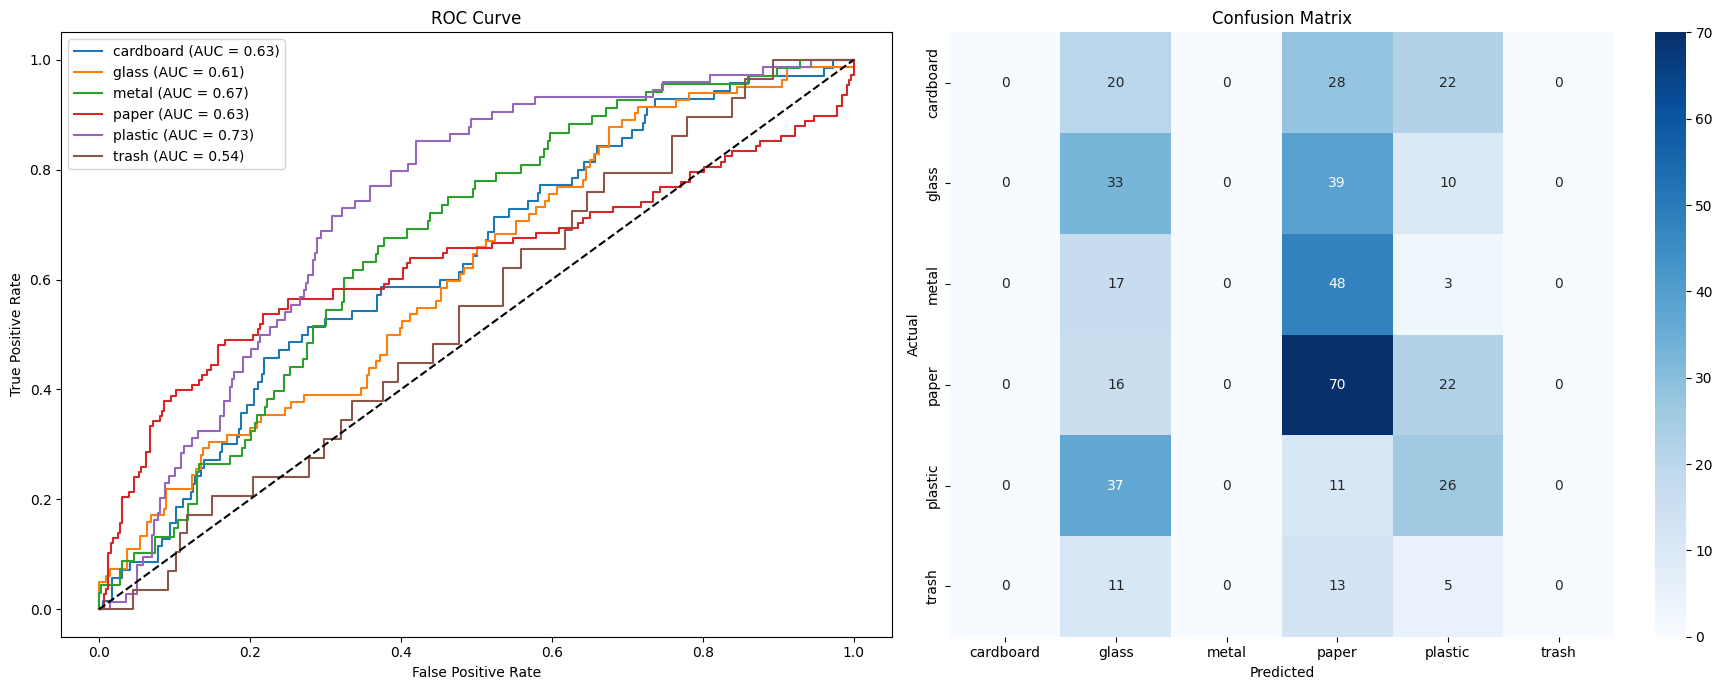

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        70
       glass       0.25      0.40      0.31        82
       metal       0.00      0.00      0.00        68
       paper       0.33      0.65      0.44       108
     plastic       0.30      0.35      0.32        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.30       431
   macro avg       0.15      0.23      0.18       431
weighted avg       0.18      0.30      0.22       431



/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/Documents/Projeto-CAA-1/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
from keras.models import load_model

print("\nLoading the model")
model = load_model('aug_resnet_model.h5')
model_l2 = load_model('aug_resnet_model_l2.h5')
model_l1 = load_model('aug_resnet_model_l1.h5')
model_dropout = load_model('aug_resnet_model_dropout.h5')
model_es = load_model('aug_resnet_model_es.h5')
model_de = load_model('aug_resnet_model_de.h5')

for m in [model, model_l2, model_l1, model_dropout, model_es, model_de]:
    print("\nEvaluating the model")
    predictions = m.predict(X_test)
    loss, accuracy = m.evaluate(X_test, y_test)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    evaluate_model(predictions, y_test, classes_names)

In [ ]:
# Function to displaying random predictions from the dataset with their images and predictions

def display_random_predictions(X, y, predictions, classes_names, number_of_predictions=5):
    plt.figure(figsize=(15, 20))

    for class_name in classes_names:
        for i in range(number_of_predictions):
            index = np.random.choice(np.where(y == class_name)[0])
            plt.subplot(len(classes_names), number_of_predictions, number_of_predictions * list(classes_names).index(class_name) + i + 1)
            plt.imshow(X[index])
            plt.title("Actual: " + class_name + "\nPredicted: " + label_encoder.classes_[np.argmax(predictions[index])])
            plt.axis('off')
    
    plt.show()

display_random_predictions(X_test, y_test, predictions, classes_names)